In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import sys 
import os

In [7]:
parent_dir = os.path.join(os.getcwd(), os.pardir)
sys.path.append(parent_dir)

In [8]:
from src import model as hp
from src import utils

In [9]:
import numpy as np
import pandas as pd
import scipy
import datetime

In [10]:
import pymc3 as pm
import theano.tensor as tt

In [11]:
import matplotlib.pyplot as plt

In [46]:
n_series = 10
n_years = 3

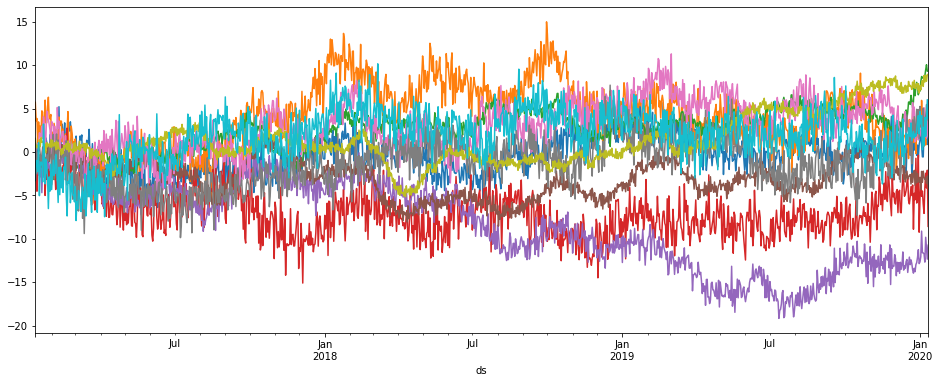

In [47]:
df = utils.random_timeseries(n_series=n_series, n_years=n_years)
df.set_index(df['ds']).drop(columns=['t', 'ds']).plot(legend=False, figsize=(16,6))

In [49]:
prophet = hp.HierarchicalProphet()
prophet.fit(df)

logp = 14,894, ||grad|| = 177.25: : 5001it [00:48, 102.76it/s]                         



In [50]:
ds, t, idx, y = hp.stack_series(df)

In [51]:
s, A = hp.changepoints(t, prophet.n_changepoints)

In [52]:
approx = prophet.pe

In [53]:
def det_seasonality_posterior(beta, x):
    return np.dot(x, beta.T)

p = 0.025
# vector distributions
pe_beta_yearly = approx['beta_365.25']
pe_beta_weekly = approx['beta_7']
pe_delta = approx['delta']

# scalar distributions
pe_k = approx['k']
pe_m = approx['m']

In [54]:
prophet.scalers['t'].scale

1095.0

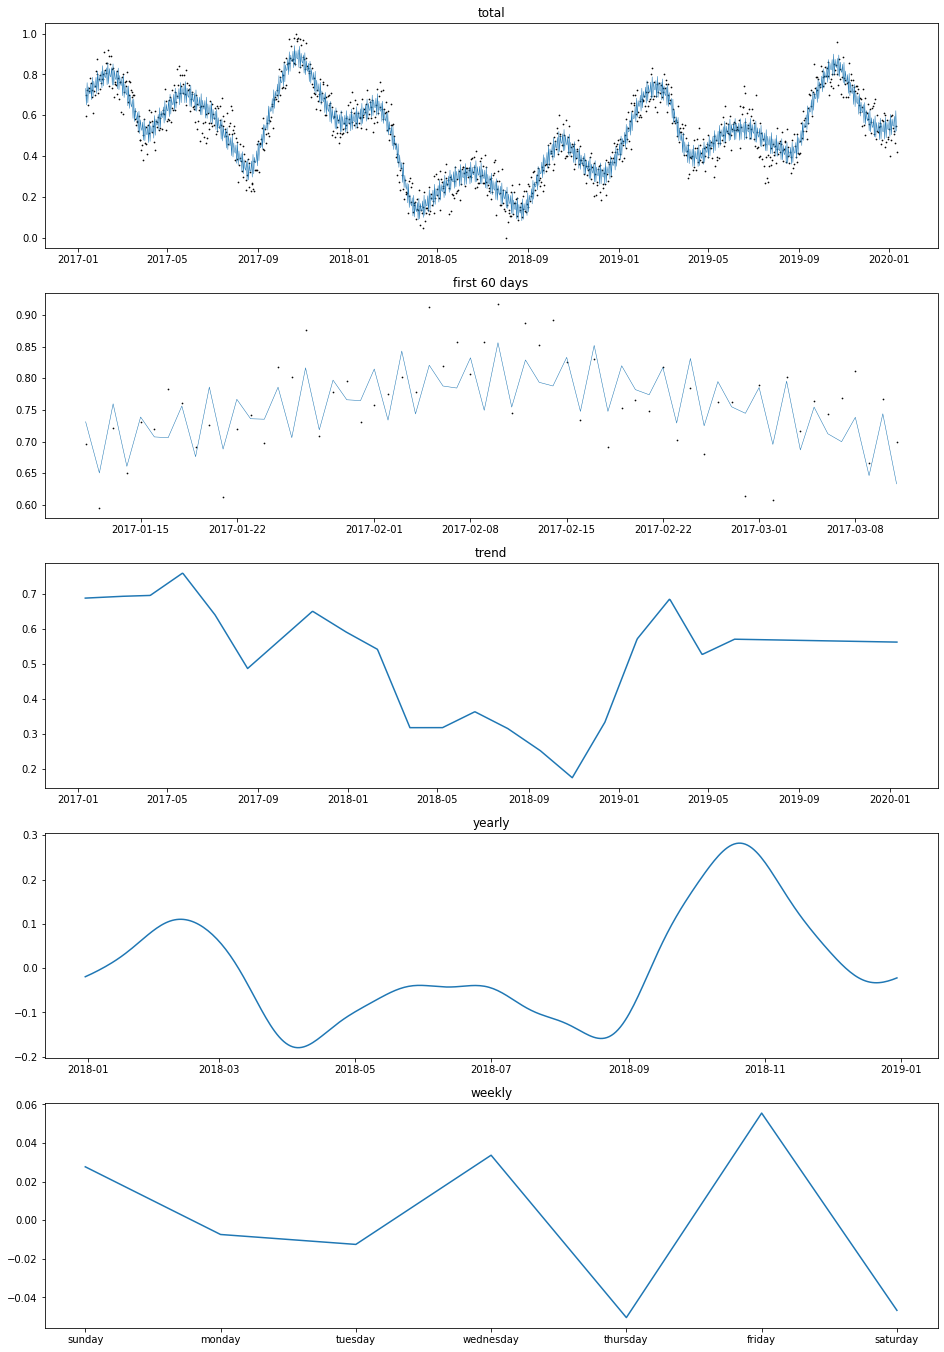

In [58]:
idx_series = 5

series_ds = ds[idx==idx_series]
series_beta_yearly = pe_beta_yearly[:,idx_series]
series_beta_weekly = pe_beta_weekly[:,idx_series]
series_t = t[idx==idx_series]
series_A = A[idx==idx_series, :]
series_F_yearly = prophet.fourier_components[0]['F'][idx==idx_series,:]
series_F_weekly = prophet.fourier_components[1]['F'][idx==idx_series,:]

# determine the posterior by evaulating all the values in the trace.
trend_posterior = (pe_k[idx_series] + np.dot(series_A, pe_delta[idx_series, :].T)) * series_t 
trend_posterior += pe_m[idx_series] + np.dot(series_A, (-s * pe_delta[idx_series, :]).T)

seasonality_yearly = det_seasonality_posterior(series_beta_yearly, series_F_yearly)
seasonality_weekly = det_seasonality_posterior(series_beta_weekly, series_F_weekly)

fitted = (trend_posterior + seasonality_yearly + seasonality_weekly) #.mean(1)

date = pd.Series(series_ds)
sunday = np.argmax(df['ds'].dt.dayofweek)
weekdays = ['sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday']
idx_year = np.argmax(df['ds'].dt.dayofyear)

plt.figure(figsize=(16, 4*6))
b = 511
plt.subplot(b)
plt.title('total')
plt.plot(date, fitted, lw=0.5)
plt.scatter(df['ds'], df['y_{}'.format(idx_series)], s=0.5, color='black')

n_days = 60
plt.subplot(b + 1)
plt.title('first {} days'.format(n_days))
plt.plot(date[:n_days], fitted[:n_days], lw=0.5)
plt.scatter(df['ds'][:n_days], df['y_{}'.format(idx_series)][:n_days], s=0.5, color='black')

plt.subplot(b + 2)
plt.title('trend')
plt.plot(date, trend_posterior[:])

plt.subplot(b + 3)
plt.title('yearly')
plt.plot(date[idx_year: idx_year + 365], seasonality_yearly[idx_year: idx_year + 365])

plt.subplot(b + 4)
plt.title('weekly')
plt.plot(weekdays, seasonality_weekly[sunday: sunday + 7])

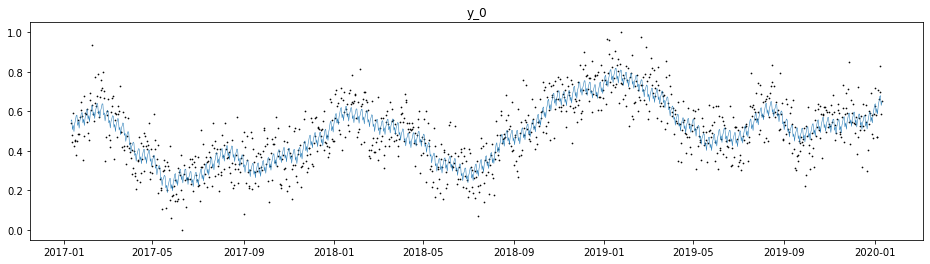

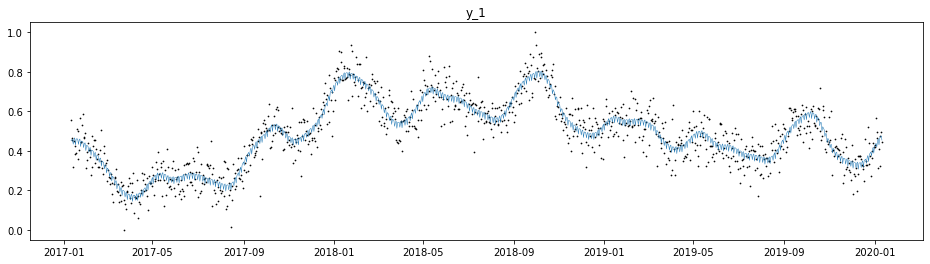

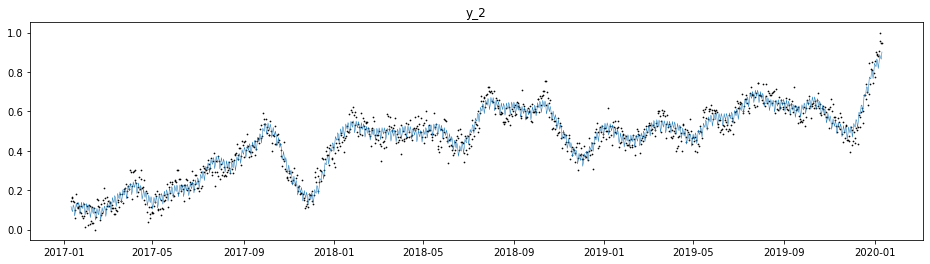

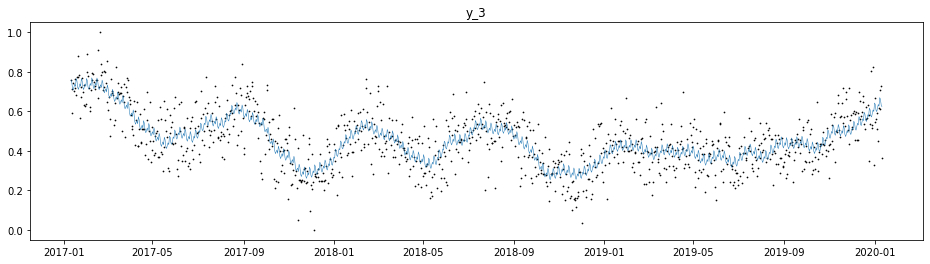

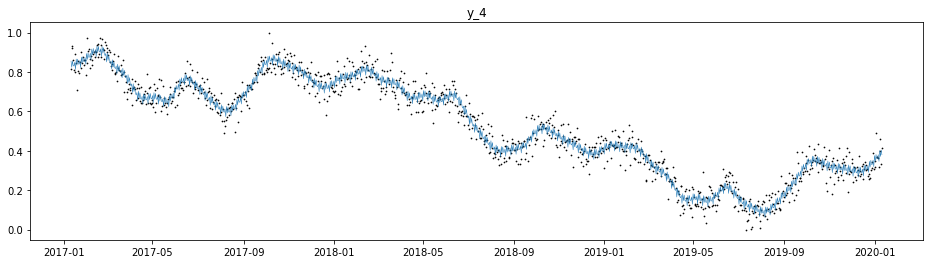

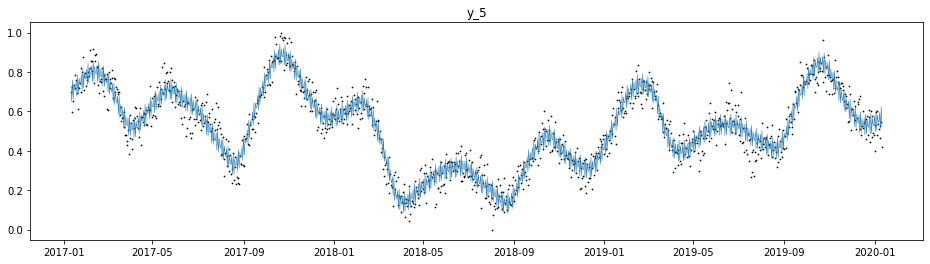

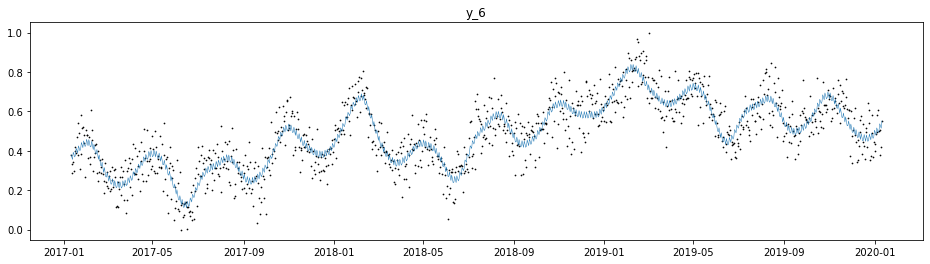

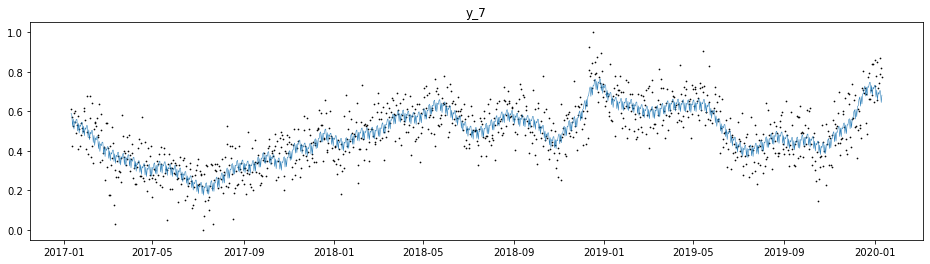

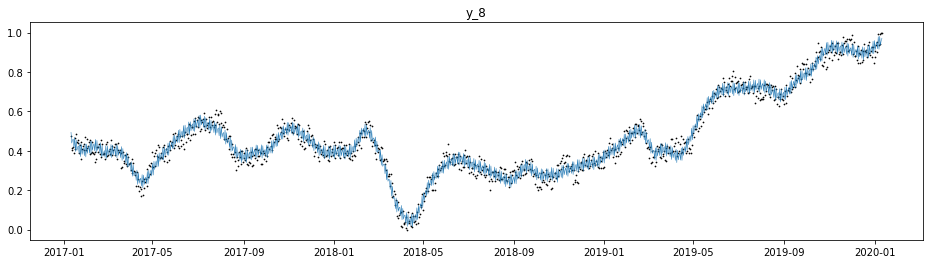

In [57]:
for idx_series in range(max(idx)):

    series_ds = ds[idx==idx_series]
    series_beta_yearly = pe_beta_yearly[:,idx_series]
    series_beta_weekly = pe_beta_weekly[:,idx_series]
    series_t = t[idx==idx_series]
    series_A = A[idx==idx_series, :]
    series_F_yearly = prophet.fourier_components[0]['F'][idx==idx_series,:]
    series_F_weekly = prophet.fourier_components[1]['F'][idx==idx_series,:]

    # determine the posterior by evaulating all the values in the trace.
    trend_posterior = (pe_k[idx_series] + np.dot(series_A, pe_delta[idx_series, :].T)) * series_t 
    trend_posterior += pe_m[idx_series] + np.dot(series_A, (-s * pe_delta[idx_series, :]).T)

    seasonality_yearly = det_seasonality_posterior(series_beta_yearly, series_F_yearly)
    seasonality_weekly = det_seasonality_posterior(series_beta_weekly, series_F_weekly)

    fitted = (trend_posterior + seasonality_yearly + seasonality_weekly) #.mean(1)

    date = pd.Series(series_ds)
    sunday = np.argmax(df['ds'].dt.dayofweek)
    weekdays = ['sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday']
    idx_year = np.argmax(df['ds'].dt.dayofyear)

    plt.figure(figsize=(16, 4))
    plt.title('y_{}'.format(idx_series))
    plt.plot(date, fitted, lw=0.5)
    plt.scatter(df['ds'], df['y_{}'.format(idx_series)], s=0.5, color='black')
    plt.show()